#Download the dataset:
https://www.kaggle.com/kazanova/sentiment140

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [ ]:
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP projects/Text_Classfication/training.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'id',
                        'date',
                        'flag',
                        'user',
                        'text'
                        ])

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.target.unique()

array([0, 4])

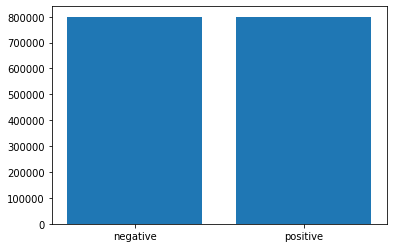

In [ ]:
classes = df.target.unique()
counts= []
for i in classes:
  count =len(df[df.target==i])
  counts.append(count)

plt.bar(['negative','positive'], counts)
plt.show()

In [ ]:
len(df[df.target==4])

800000

In [ ]:
sample_data = int(len(df)*0.5)
sample_df = df.sample(sample_data, random_state= 25)

In [ ]:
len(df)

x = sample_df.text.values
y = sample_df.target.values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state =42)

#Tokenization

What we need to do now is to tokenize text (essentialy turning words into tokens). The difference from vectorization that we used in Linear Regression notebook is that we do not count each token occurence in the text. Instead we just turn words into tokens and that's about it. Comparing this to Logistic Regression (LR) example you'll see that in this method we keep the order of the words intact, while, in the LR example we loose that information.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

In [ ]:
print(x_train[6], '\n', X_train[6])

@thefashionbomb good morning. Did you take that run today  
 [51475, 29, 97, 125, 7, 174, 17, 489, 41]


# Padding
Before modelling we want to make sure our inputs are the same size, since we are using neural network with a fixed input size.
First we figure out the max len.

In [ ]:
# Checking the max length
len_train = [len(i) for i in X_train]
len_test = [len(i) for i in X_test]
lens = len_train +len_test

maxlen = np.max(lens)
print('Max length',maxlen)

Max length 118


In [ ]:
X_train = pad_sequences(X_train , padding ='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#Label Encoding
We could get away with other approach but you might want to use this for more than binary classification.

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoder_Y_train = encoder.transform(y_train)
encoder_Y_test = encoder.transform(y_test)

In [ ]:
# Convert intergers to dummy variables (i.e one hot encoded)
dummy_Y_train = to_categorical(encoder_Y_train)
dummy_Y_test = to_categorical(encoder_Y_test)

#Modelling
The model that we use here is a simple Neural Network. I'll add some comments to explain what each line does.

In [ ]:
embedding_dim = 100       # vector representation of words/neuron amount after the input https://datascience.stackexchange.com/questions/53995/what-does-embedding-mean-in-machine-learning#:~:text=In%20the%20context%20of%20machine,with%20other%20models%20as%20well.

model = Sequential([layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
                   layers.Dropout(0.2),
                   layers.GlobalMaxPooling1D(),
                   layers.Dropout(0.2),
                   layers.Dense(50,activation='relu'),
                   layers.Dropout(0.2),
                   layers.Dense(50,activation='relu'),
                   layers.Dropout(0.2),
                   layers.Dense(2, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, dummy_Y_train,
                    epochs = 5,
                    verbose =True,
                    validation_data=(X_test, dummy_Y_test),
                    batch_size =500)

Epoch 1/5
1280/1280 [==============================] - 308s 240ms/step - loss: 0.4742 - accuracy: 0.7725 - val_loss: 0.4265 - val_accuracy: 0.8018
Epoch 2/5
1280/1280 [==============================] - 311s 243ms/step - loss: 0.3915 - accuracy: 0.8217 - val_loss: 0.4268 - val_accuracy: 0.8026
Epoch 3/5
1280/1280 [==============================] - 313s 245ms/step - loss: 0.3373 - accuracy: 0.8509 - val_loss: 0.4467 - val_accuracy: 0.7972
Epoch 4/5
1280/1280 [==============================] - 307s 240ms/step - loss: 0.2928 - accuracy: 0.8753 - val_loss: 0.4749 - val_accuracy: 0.7890
Epoch 5/5
1280/1280 [==============================] - 308s 240ms/step - loss: 0.2611 - accuracy: 0.8912 - val_loss: 0.5117 - val_accuracy: 0.7821


In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_Y_train, verbose=False)
accuracy

0.9278656244277954

In [ ]:
loss, accuracy= model.evaluate(X_test, dummy_Y_test, verbose=False)
accuracy

0.7820749878883362

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1,6)

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'b', label= ' Training acc')
  plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
  plt.title('Training and validation accuracy vs epochs')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'b', label= ' Training loss')
  plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
  plt.title('Training and validation loss vs epochs')
  plt.legend()

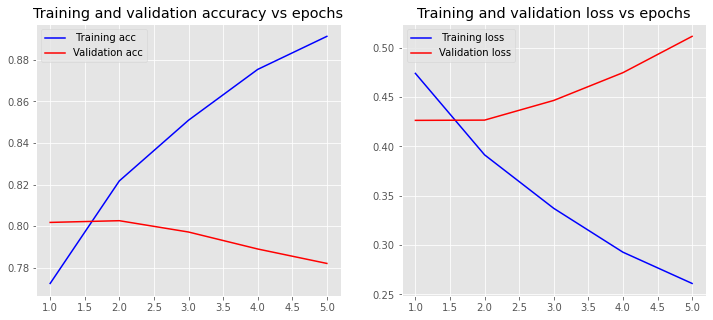

In [ ]:
plot_history(history)

So there's a couple of interesting things we can see here. Ussually you would see train and validation accuracy both increase over time. Essentially the point where training crosses validation you would want to stop training as it means that model is starting to remember exact things instead of learning patterns, which here is at 2nd epoch. Another thing to take into account is that validation accuracy decreases quite singnificantly over time, instead of growing. Why? Well we have quite a lot of data, so it might very well be that it's enough to have 2 epochs to fully train it before changing learning rate. Essentially, what this shows is that model is rapidly overtraining.  

In [ ]:
 encoder.classes_

array([0, 4])

And our predictions are stored as arrays with probabilities fir each class.

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[0.29998654, 0.6993418 ],
       [0.70481646, 0.29435351],
       [0.00518721, 0.9947592 ],
       ...,
       [0.79028416, 0.20838329],
       [0.8754104 , 0.12497222],
       [0.98322994, 0.01708755]], dtype=float32)

Here you can see that we have array of arrays of 2 probabilities for each class. So we need to turn those into classes.

In [ ]:
y_predDecoded = [encoder.classes_[np.argmax(i)] for i in y_pred]  # here we get the max probability from those arrays and then based on that select which class is it.
cm = confusion_matrix(y_test, y_predDecoded, labels=df.target.unique())  # same confusion matrix code as in Logistic Regression
df_cm = pd.DataFrame(cm, index=df.target.unique(), columns=df.target.unique())
df_cm

,0,4
0,63809,16134
4,18734,61323


In [ ]:
# IN percentage

df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,0,4
0,0.77304,0.208296
4,0.22696,0.791704


#Test

Now we need to check if it actually works. Let's just copy a comment in one of Trump's tweet.


The comment is: 
PATRIOTIC AMERICANS STAND PROUDLY WITH PRESIDENT TRUMP!!

In [ ]:
tweet = 'People are fleeing California. Taxes too high, Crime too high, Brownouts too many, Lockdowns too severe. VOTE FOR TRUMP, WHAT THE HELL DO YOU HAVE TO LOSE!!!'
vectTweet = tokenizer.texts_to_sequences(np.array([tweet]))  # vectorizes the tweet using our vectorizer
vectTweet = pad_sequences(vectTweet, padding='post', maxlen=maxlen)  # adds padding

prediction = model.predict(vectTweet)  # predicts class of the tweet
print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]==4 else 'negative')

Tweet is negative


In [ ]:
tweetList = ['Best tweet ever!', 'Mondays are the worst...']
vectTweet = tokenizer.texts_to_sequences(np.array(tweetList))  # vectorizes the tweet using our vectorizer
vectTweet = pad_sequences(vectTweet, padding='post', maxlen=maxlen)  # adds padding

prediction = model.predict(vectTweet)  # predicts class of the tweet
for enum, i in enumerate(tweetList):
  print(i, '| This tweet is', 'positive' if encoder.classes_[np.argmax(prediction[enum])]==4 else 'negative')

Best tweet ever! | This tweet is positive
Mondays are the worst... | This tweet is negative
